# Snow Scope Analysis
## Analyzing how distance from trees impacts snow depth and strength profiles

This notebook analyzes Snow Scope micropenetrometer data from Berthoud Pass and examines the relationship between tree proximity and snow properties.

## 1. Import Libraries

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (20, 10)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## 2. Configuration - Set Your File Paths

Update these paths to match your file locations:

In [37]:
# Directory containing your Snow Scope CSV files
data_directory = '/Users/milliespencer/Desktop/snowscope_berthoud'

# Path to your tree distance CSV file
tree_distance_file = '/Users/milliespencer/Desktop/snowscope_berthoud/tree_dist_and_strat/Pit_Snowscope_Processed.csv'

print(f"Data directory: {data_directory}")
print(f"Tree distance file: {tree_distance_file}")

Data directory: /Users/milliespencer/Desktop/snowscope_berthoud
Tree distance file: /Users/milliespencer/Desktop/snowscope_berthoud/tree_dist_and_strat/Pit_Snowscope_Processed.csv


## 3. Load Snow Scope Data

This cell loads all CSV files from your directory and extracts profile numbers.

In [38]:
def load_snow_scope_data(data_directory):
    """
    Load all CSV files from the specified directory
    
    Parameters:
    data_directory (str): Path to directory containing CSV files
    
    Returns:
    list: List of tuples (filename, dataframe, profile_number)
    """
    data_files = []
    path = Path(data_directory)
    
    # Get all CSV files
    csv_files = list(path.glob('*.csv'))
    
    # Exclude tree_distances.csv if present
    csv_files = [f for f in csv_files if 'tree_distance' not in f.name.lower()]
    
    if len(csv_files) == 0:
        print(f"No CSV files found in {data_directory}")
        return []
    
    print(f"Found {len(csv_files)} CSV files")
    
    # Load files and extract profile numbers
    files_with_profiles = []
    for csv_file in csv_files:
        try:
            # Read file and find where "depth (mm)" header starts
            with open(csv_file, 'r') as f:
                lines = f.readlines()
            
            # Find the line with "depth (mm)" header
            header_line = None
            for i, line in enumerate(lines):
                if 'depth (mm)' in line.lower():
                    header_line = i
                    break
            
            if header_line is None:
                print(f"⚠️  Could not find data header in {csv_file.name}")
                continue
            
            # Read CSV starting from the header line, only first 2 columns
            df = pd.read_csv(csv_file, skiprows=header_line, usecols=[0, 1])
            
            # Clean column names
            df.columns = ['depth_mm', 'hardness_kPa']

            # Convert to numeric (in case they were read as strings)
            df['depth_mm'] = pd.to_numeric(df['depth_mm'], errors='coerce')
            df['hardness_kPa'] = pd.to_numeric(df['hardness_kPa'], errors='coerce')
            
            # Remove any rows with NaN values
            df = df.dropna()
            
            # OPTIONAL: Remove zero hardness values (often indicate end of snowpack/sensor issues)
            # Comment out the next line if you want to include zeros in your analysis
            # df = df[df['hardness_kPa'] > 0]

            # Extract profile number from filename
            filename = csv_file.name
            if 'Profile' in filename:
                profile_num = int(filename.split('Profile')[1].split('_')[0])
            else:
                profile_num = 999
            
            files_with_profiles.append((filename, df, profile_num))
            print(f"✅ Loaded: {filename} (Profile {profile_num}) - Shape: {df.shape}")
            
        except Exception as e:
            print(f"❌ Error loading {csv_file.name}: {e}")
    
    # Sort by profile number
    files_with_profiles.sort(key=lambda x: x[2])
    
    print(f"\nProfile numbers found: {[f[2] for f in files_with_profiles]}")
    
    return files_with_profiles

# Load the data
data_files = load_snow_scope_data(data_directory)
print(f"\n✅ Successfully loaded {len(data_files)} files")

Found 31 CSV files
✅ Loaded: 2026-01-08_1302_Profile159_SN00304.csv (Profile 159) - Shape: (739, 2)
✅ Loaded: 2026-01-08_1303_Profile161_SN00304.csv (Profile 161) - Shape: (621, 2)
✅ Loaded: 2026-01-08_1133_Profile147_SN00304.csv (Profile 147) - Shape: (676, 2)
✅ Loaded: 2026-01-08_1101_Profile142_SN00304.csv (Profile 142) - Shape: (252, 2)
✅ Loaded: 2026-01-08_1135_Profile151_SN00304.csv (Profile 151) - Shape: (681, 2)
✅ Loaded: 2026-01-08_1334_Profile172_SN00304.csv (Profile 172) - Shape: (761, 2)
✅ Loaded: 2026-01-08_1323_Profile166_SN00304.csv (Profile 166) - Shape: (705, 2)
✅ Loaded: 2026-01-08_1205_Profile156_SN00304.csv (Profile 156) - Shape: (539, 2)
✅ Loaded: 2026-01-08_1204_Profile155_SN00304.csv (Profile 155) - Shape: (562, 2)
✅ Loaded: 2026-01-08_1333_Profile171_SN00304.csv (Profile 171) - Shape: (772, 2)
✅ Loaded: 2026-01-08_1057_Profile140_SN00304.csv (Profile 140) - Shape: (295, 2)
✅ Loaded: 2026-01-08_1323_Profile165_SN00304.csv (Profile 165) - Shape: (796, 2)
✅ Loaded:

## 4. Inspect Data Structure

Let's look at the first file to understand the data format:

In [39]:
if len(data_files) > 0:
    filename, df, profile_num = data_files[0]
    print(f"Example file: {filename}")
    print(f"Profile number: {profile_num}")
    print(f"\nDataFrame shape: {df.shape}")
    print(f"Number of measurements: {df.shape[0]}")
    print(f"\nColumn names: {list(df.columns)}")
    print(f"\nFirst few rows:")
    display(df.head(10))
    
    # OPTIONAL: Filter out zero hardness values (often indicate end of snowpack/sensor issues)
    # Comment out the next line if you want to include zeros in your analysis
    df_filtered = df[df['hardness_kPa'] > 0]
    
    print(f"\nProfile summary:")
    print(f"  Total snow depth: {df['depth_mm'].max():.1f} mm")
    print(f"  Measurements with hardness > 0: {len(df_filtered)} / {len(df)}")
    print(f"\nHardness statistics (excluding zeros):")
    print(f"  Mean: {df_filtered['hardness_kPa'].mean():.2f} kPa")
    
    # Find max hardness and its depth
    max_idx = df_filtered['hardness_kPa'].idxmax()
    max_hardness = df_filtered.loc[max_idx, 'hardness_kPa']
    max_depth = df_filtered.loc[max_idx, 'depth_mm']
    print(f"  Max: {max_hardness:.2f} kPa at depth {max_depth:.1f} mm")
    
    # Find min hardness and its depth
    min_idx = df_filtered['hardness_kPa'].idxmin()
    min_hardness = df_filtered.loc[min_idx, 'hardness_kPa']
    min_depth = df_filtered.loc[min_idx, 'depth_mm']
    print(f"  Min: {min_hardness:.2f} kPa at depth {min_depth:.1f} mm")
    
    print(f"  Median: {df_filtered['hardness_kPa'].median():.2f} kPa")
else:
    print("No data files loaded!")

Example file: 2026-01-08_1057_Profile140_SN00304.csv
Profile number: 140

DataFrame shape: (295, 2)
Number of measurements: 295

Column names: ['depth_mm', 'hardness_kPa']

First few rows:


,depth_mm,hardness_kPa
6,1.0,0.44
7,2.0,0.64
8,3.0,0.64
9,4.0,0.54
10,5.0,0.79
11,6.0,0.79
12,7.0,0.79
13,8.0,0.69
14,9.0,0.84
15,10.0,0.84



Profile summary:
  Total snow depth: 295.0 mm
  Measurements with hardness > 0: 294 / 295

Hardness statistics (excluding zeros):
  Mean: 7.61 kPa
  Max: 575.21 kPa at depth 294.0 mm
  Min: 0.44 kPa at depth 1.0 mm
  Median: 3.92 kPa


## 5. Load Tree Distance Data

Load the CSV file containing tree distance measurements for each profile.

In [40]:
def load_tree_distance_data(csv_file_path):
    """
    Load tree distance data from CSV file
    
    Parameters:
    csv_file_path (str): Path to CSV file with tree distance data
    
    Returns:
    DataFrame: Tree distance data indexed by profile number
    """
    try:
        df = pd.read_csv(csv_file_path)
        
        # Select only the columns we need: ProfileID and Distance_from_tree_meters
        df_clean = df[['ProfileID', 'Distance_from_tree_meters']].copy()
        
        # Rename for clarity
        df_clean.columns = ['profile_number', 'distance_from_trees_m']
        
        # Remove any duplicates (keep first occurrence)
        df_clean = df_clean.drop_duplicates(subset='profile_number', keep='first')
        
        print(f"✅ Loaded tree distance data: {len(df_clean)} profiles")
        print(f"\nFirst few rows:")
        display(df_clean.head(10))
        
        print(f"\nDistance range: {df_clean['distance_from_trees_m'].min():.1f} - {df_clean['distance_from_trees_m'].max():.1f} meters")
        
        return df_clean
        
    except FileNotFoundError:
        print(f"❌ File not found: {csv_file_path}")
        print("Make sure the path is correct!")
        return None
    except Exception as e:
        print(f"❌ Error loading tree distance data: {e}")
        return None

# Load tree distance data
tree_distance_df = load_tree_distance_data(tree_distance_file)

✅ Loaded tree distance data: 31 profiles

First few rows:


,profile_number,distance_from_trees_m
0,140,1
1,141,1
2,142,1
3,143,1
4,144,1
5,145,1
6,146,4
7,147,4
8,148,4
9,150,4



Distance range: 1.0 - 8.0 meters


## 6. Calculate Statistics for Each Profile

Calculate key metrics (depth, strength, etc.) for each profile and merge with tree distance data.

In [41]:
def calculate_statistics_with_trees(data_files, tree_distance_df):
    """
    Calculate statistics for each measurement including tree distance
    
    Parameters:
    data_files (list): List of tuples (filename, dataframe, profile_number)
    tree_distance_df (DataFrame): Tree distance data
    
    Returns:
    DataFrame: Summary statistics with tree distances
    """
    stats_list = []
    
    for filename, df, profile_num in data_files:
        # Adjust column names based on actual CSV structure
        depth_col = df.columns[0]
        force_col = df.columns[1]
        
        # Get tree distance for this profile
        tree_dist = None
        if tree_distance_df is not None:
            # Flexible column name matching
            profile_col = [col for col in tree_distance_df.columns if 'profile' in col.lower()][0]
            distance_col = [col for col in tree_distance_df.columns if 'distance' in col.lower()][0]
            
            match = tree_distance_df[tree_distance_df[profile_col] == profile_num]
            if not match.empty:
                tree_dist = match[distance_col].values[0]
        
        stats = {
            'profile_number': profile_num,
            'filename': filename,
            'distance_from_trees_m': tree_dist,
            'max_depth_cm': df[depth_col].max(),
            'min_depth_cm': df[depth_col].min(),
            'mean_force': df[force_col].mean(),
            'max_force': df[force_col].max(),
            'median_force': df[force_col].median(),
            'std_force': df[force_col].std(),
            'total_force': df[force_col].sum(),  # Bulk strength proxy
            'n_measurements': len(df)
        }
        stats_list.append(stats)
    
    stats_df = pd.DataFrame(stats_list)
    return stats_df

# Calculate statistics
stats_df = calculate_statistics_with_trees(data_files, tree_distance_df)

print(f"\n✅ Calculated statistics for {len(stats_df)} profiles")
print(f"\nSummary statistics:")
display(stats_df.head(10))


✅ Calculated statistics for 31 profiles

Summary statistics:


,profile_number,filename,distance_from_trees_m,max_depth_cm,min_depth_cm,mean_force,max_force,median_force,std_force,total_force,n_measurements
0,140,2026-01-08_1057_Profile140_SN00304.csv,1,295.0,1.0,7.587695,575.21,3.920,34.811646,2238.37,295
1,141,2026-01-08_1059_Profile141_SN00304.csv,1,312.0,1.0,11.758397,501.52,4.970,47.756289,3668.62,312
2,142,2026-01-08_1101_Profile142_SN00304.csv,1,252.0,1.0,3.740119,184.80,1.855,16.259040,942.51,252
3,143,2026-01-08_1102_Profile143_SN00304.csv,1,332.0,1.0,5.186416,161.88,2.980,11.233303,1721.89,332
4,144,2026-01-08_1102_Profile144_SN00304.csv,1,308.0,1.0,16.399578,451.50,4.470,63.160721,5051.07,308
5,145,2026-01-08_1103_Profile145_SN00304.csv,1,352.0,1.0,11.893750,417.29,4.920,38.119300,4186.60,352
6,146,2026-01-08_1130_Profile146_SN00304.csv,4,712.0,1.0,16.039649,363.50,8.375,30.310809,11420.23,712
7,147,2026-01-08_1133_Profile147_SN00304.csv,4,676.0,1.0,15.863107,264.26,10.040,27.238250,10723.46,676
8,148,2026-01-08_1134_Profile148_SN00304.csv,4,703.0,1.0,13.023343,116.79,7.150,17.484218,9155.41,703
9,150,2026-01-08_1135_Profile150_SN00304.csv,4,725.0,1.0,13.350069,153.38,10.040,12.644124,9678.80,725


## 7. View Summary Statistics

Get an overview of the data:

In [42]:
print("Overall Statistics:")
display(stats_df.describe())

# Check for missing tree distance data
missing_tree_data = stats_df[stats_df['distance_from_trees_m'].isna()]
if len(missing_tree_data) > 0:
    print(f"\n⚠️  Warning: {len(missing_tree_data)} profiles missing tree distance data:")
    print(missing_tree_data['profile_number'].values)
else:
    print("\n✅ All profiles have tree distance data!")

Overall Statistics:


,profile_number,distance_from_trees_m,max_depth_cm,min_depth_cm,mean_force,max_force,median_force,std_force,total_force,n_measurements
count,31.000000,31.000000,31.000000,31.0,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000
mean,156.354839,4.225806,629.612903,1.0,14.577045,255.587742,8.942581,23.339152,9585.546129,629.612903
std,10.137549,2.929274,176.737221,0.0,5.515818,144.194002,4.601310,11.827992,4750.674742,176.737221
min,140.000000,1.000000,252.000000,1.0,2.128915,30.320000,0.000000,4.414283,942.510000,252.000000
25%,147.500000,1.000000,556.500000,1.0,12.458546,146.745000,4.945000,15.989156,4910.895000,556.500000
50%,156.000000,4.000000,705.000000,1.0,16.039649,231.290000,10.040000,19.600643,10723.460000,705.000000
75%,164.500000,8.000000,759.500000,1.0,18.562520,309.950000,12.265000,28.430779,12835.390000,759.500000
max,173.000000,8.000000,812.000000,1.0,21.967194,576.050000,17.940000,63.160721,17222.280000,812.000000



✅ All profiles have tree distance data!


## 8. Correlation Analysis 1

Test for statistical relationships between vertical depth and snow hardness:


TOP 2 HARDEST LAYERS BY SNOWPACK SECTION ANALYSIS
Dividing snowpack into 8 sections (0-12.5%, 12.5-25%, etc.)

Analyzed 31 profiles

SECTION FREQUENCY ANALYSIS

1st HARDEST LAYER - Frequency by section:
  0-12.5%    (Section 0):  0 profiles (  0.0%) 
  12.5-25%   (Section 1):  1 profiles (  3.2%) █
  25-37.5%   (Section 2):  5 profiles ( 16.1%) ████████
  37.5-50%   (Section 3): 10 profiles ( 32.3%) ████████████████
  50-62.5%   (Section 4):  0 profiles (  0.0%) 
  62.5-75%   (Section 5):  0 profiles (  0.0%) 
  75-87.5%   (Section 6):  1 profiles (  3.2%) █
  87.5-100%  (Section 7): 14 profiles ( 45.2%) ██████████████████████

  → Most common section: 87.5-100% (14 profiles)

2nd HARDEST LAYER - Frequency by section:
  0-12.5%    (Section 0):  0 profiles (  0.0%) 
  12.5-25%   (Section 1):  1 profiles (  3.2%) █
  25-37.5%   (Section 2):  2 profiles (  6.5%) ███
  37.5-50%   (Section 3):  7 profiles ( 22.6%) ███████████
  50-62.5%   (Section 4):  0 profiles (  0.0%) 
  62.5-75%   (Sec

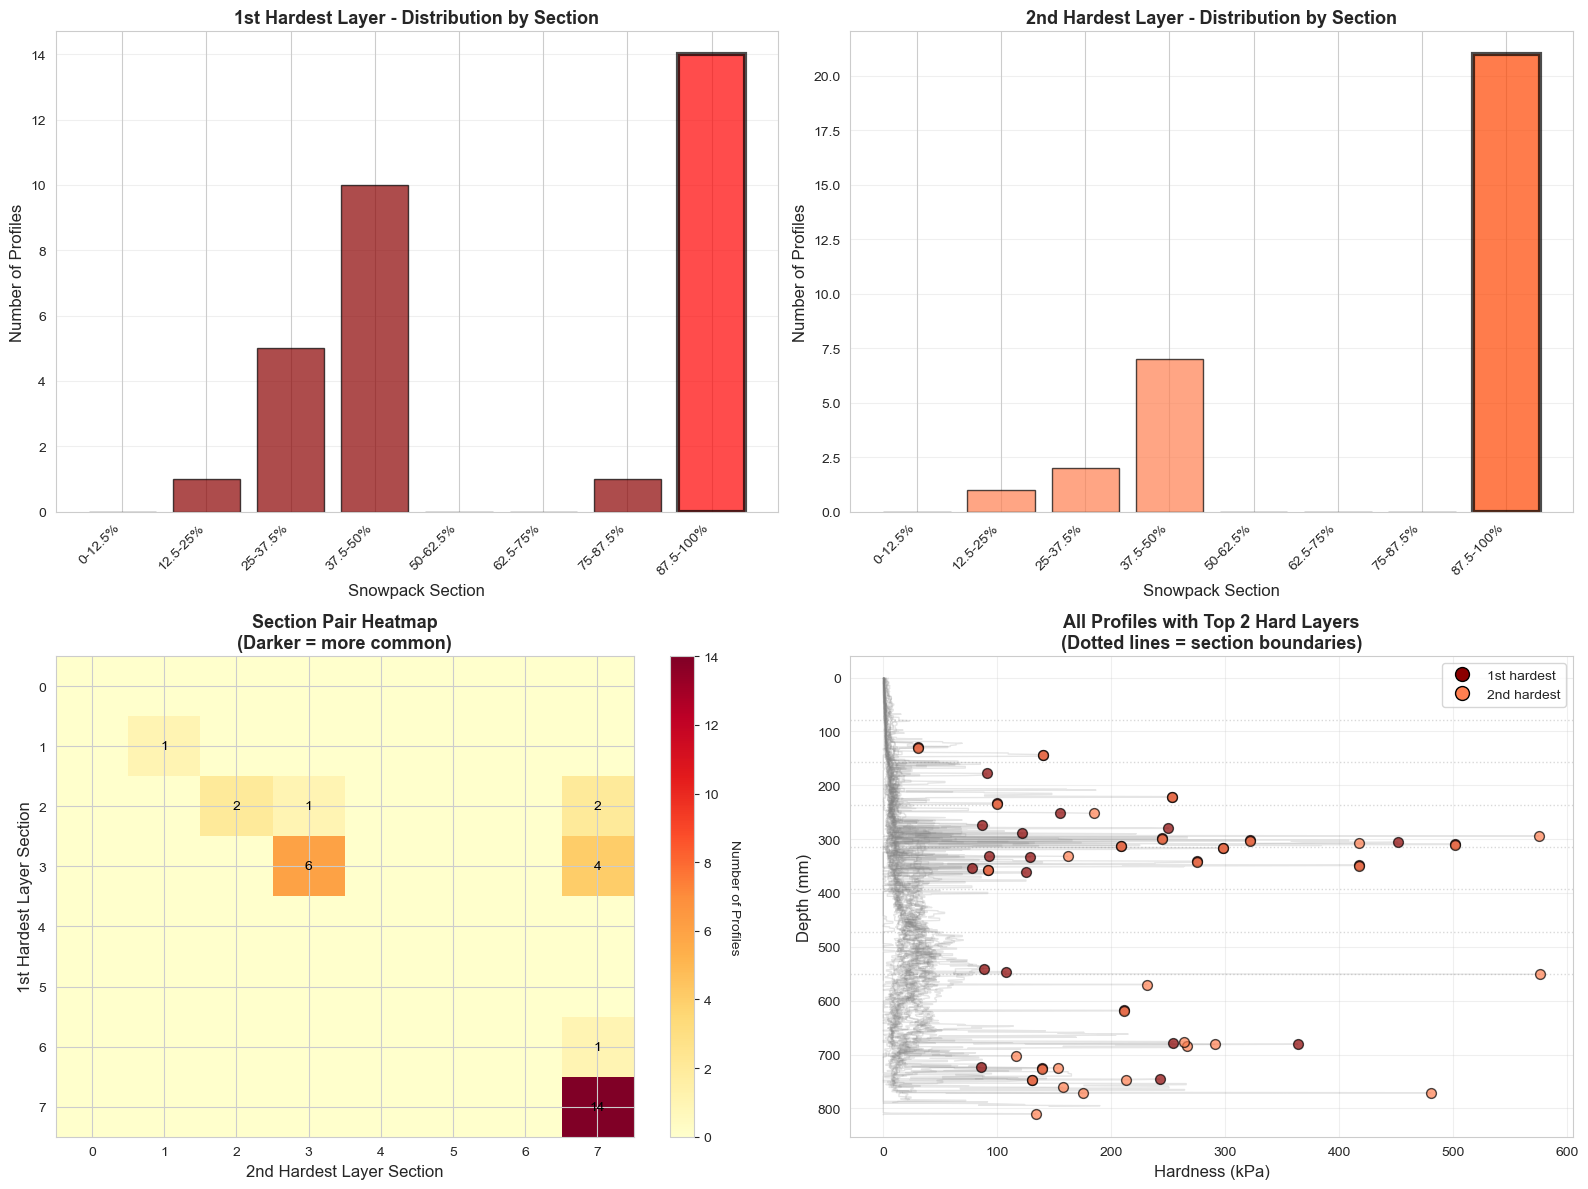


STATISTICAL TEST - Are hard layers randomly distributed?

1st Hardest Layer:
  Chi-square test: χ² = 52.35, p = 0.0000
  ✓ Significant: 1st hardest layer is NOT randomly distributed
    (Clustered in certain sections)

2nd Hardest Layer:
  Chi-square test: χ² = 96.74, p = 0.0000
  ✓ Significant: 2nd hardest layer is NOT randomly distributed
    (Clustered in certain sections)



In [43]:
# Analyze top 2 hardest layers by snowpack section (octiles - 8 sections)

print("=" * 80)
print("TOP 2 HARDEST LAYERS BY SNOWPACK SECTION ANALYSIS")
print("=" * 80)
print("Dividing snowpack into 8 sections (0-12.5%, 12.5-25%, etc.)")
print("=" * 80)

# Collect data from ALL profiles
all_hard_layers_data = []

for filename, df, profile_num in data_files:
    # Find top 2 hardest measurements
    top_2 = df.nlargest(2, 'hardness_kPa')
    
    if len(top_2) >= 2:
        # Sort by depth to identify which is shallower
        top_2_sorted = top_2.sort_values('depth_mm')
        
        layer_1_depth = top_2_sorted.iloc[0]['depth_mm']
        layer_1_hardness = top_2_sorted.iloc[0]['hardness_kPa']
        
        layer_2_depth = top_2_sorted.iloc[1]['depth_mm']
        layer_2_hardness = top_2_sorted.iloc[1]['hardness_kPa']
        
        total_depth = df['depth_mm'].max()
        
        # Calculate which octile (0-7) each layer falls into
        # 0 = top 12.5%, 1 = 12.5-25%, ..., 7 = 87.5-100% (bottom)
        layer_1_octile = int((layer_1_depth / total_depth) * 8)
        layer_1_octile = min(layer_1_octile, 7)  # Cap at 7 for bottom section
        
        layer_2_octile = int((layer_2_depth / total_depth) * 8)
        layer_2_octile = min(layer_2_octile, 7)
        
        # Calculate separation
        layer_separation = abs(layer_2_depth - layer_1_depth)
        
        all_hard_layers_data.append({
            'profile_number': profile_num,
            'layer_1_depth_mm': layer_1_depth,
            'layer_1_hardness_kPa': layer_1_hardness,
            'layer_1_octile': layer_1_octile,
            'layer_2_depth_mm': layer_2_depth,
            'layer_2_hardness_kPa': layer_2_hardness,
            'layer_2_octile': layer_2_octile,
            'layer_separation_mm': layer_separation,
            'total_depth_mm': total_depth
        })

hard_layers_df = pd.DataFrame(all_hard_layers_data)

print(f"\nAnalyzed {len(hard_layers_df)} profiles")

# Count frequency of each octile for each layer
octile_labels = ['0-12.5%', '12.5-25%', '25-37.5%', '37.5-50%', 
                 '50-62.5%', '62.5-75%', '75-87.5%', '87.5-100%']

layer_1_counts = hard_layers_df['layer_1_octile'].value_counts().sort_index()
layer_2_counts = hard_layers_df['layer_2_octile'].value_counts().sort_index()

print("\n" + "=" * 80)
print("SECTION FREQUENCY ANALYSIS")
print("=" * 80)

print("\n1st HARDEST LAYER - Frequency by section:")
for octile in range(8):
    count = layer_1_counts.get(octile, 0)
    pct = (count / len(hard_layers_df)) * 100
    bar = '█' * int(pct / 2)  # Visual bar
    print(f"  {octile_labels[octile]:10s} (Section {octile}): {count:2d} profiles ({pct:5.1f}%) {bar}")

most_common_1 = layer_1_counts.idxmax()
print(f"\n  → Most common section: {octile_labels[most_common_1]} ({layer_1_counts[most_common_1]} profiles)")

print("\n2nd HARDEST LAYER - Frequency by section:")
for octile in range(8):
    count = layer_2_counts.get(octile, 0)
    pct = (count / len(hard_layers_df)) * 100
    bar = '█' * int(pct / 2)
    print(f"  {octile_labels[octile]:10s} (Section {octile}): {count:2d} profiles ({pct:5.1f}%) {bar}")

most_common_2 = layer_2_counts.idxmax()
print(f"\n  → Most common section: {octile_labels[most_common_2]} ({layer_2_counts[most_common_2]} profiles)")

# Check if the same two sections consistently have the hard layers
print("\n" + "=" * 80)
print("SECTION PAIR ANALYSIS")
print("=" * 80)

# Create pairs (sorted so order doesn't matter)
hard_layers_df['octile_pair'] = hard_layers_df.apply(
    lambda row: tuple(sorted([int(row['layer_1_octile']), int(row['layer_2_octile'])])), 
    axis=1
)

pair_counts = hard_layers_df['octile_pair'].value_counts()

print("\nMost common section pairs (where 1st and 2nd hardest layers occur together):")
for idx, (pair, count) in enumerate(pair_counts.head(5).items()):
    pct = (count / len(hard_layers_df)) * 100
    pair_0 = int(pair[0])
    pair_1 = int(pair[1])
    if pair_0 == pair_1:
        print(f"  {idx+1}. Both in {octile_labels[pair_0]}: {count} profiles ({pct:.1f}%)")
    else:
        print(f"  {idx+1}. Sections {octile_labels[pair_0]} & {octile_labels[pair_1]}: {count} profiles ({pct:.1f}%)")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Bar chart of 1st hardest layer by section
ax = axes[0, 0]
layer_1_full = pd.Series([layer_1_counts.get(i, 0) for i in range(8)])
bars1 = ax.bar(range(8), layer_1_full, color='darkred', edgecolor='black', alpha=0.7)
ax.set_xlabel('Snowpack Section', fontsize=12)
ax.set_ylabel('Number of Profiles', fontsize=12)
ax.set_title('1st Hardest Layer - Distribution by Section', fontsize=13, fontweight='bold')
ax.set_xticks(range(8))
ax.set_xticklabels(octile_labels, rotation=45, ha='right')
ax.grid(True, alpha=0.3, axis='y')

# Highlight most common
bars1[most_common_1].set_color('red')
bars1[most_common_1].set_edgecolor('black')
bars1[most_common_1].set_linewidth(3)

# Plot 2: Bar chart of 2nd hardest layer by section
ax = axes[0, 1]
layer_2_full = pd.Series([layer_2_counts.get(i, 0) for i in range(8)])
bars2 = ax.bar(range(8), layer_2_full, color='coral', edgecolor='black', alpha=0.7)
ax.set_xlabel('Snowpack Section', fontsize=12)
ax.set_ylabel('Number of Profiles', fontsize=12)
ax.set_title('2nd Hardest Layer - Distribution by Section', fontsize=13, fontweight='bold')
ax.set_xticks(range(8))
ax.set_xticklabels(octile_labels, rotation=45, ha='right')
ax.grid(True, alpha=0.3, axis='y')

# Highlight most common
bars2[most_common_2].set_color('orangered')
bars2[most_common_2].set_edgecolor('black')
bars2[most_common_2].set_linewidth(3)

# Plot 3: Heatmap of section pairs
ax = axes[1, 0]
pair_matrix = np.zeros((8, 8))
for _, row in hard_layers_df.iterrows():
    pair_matrix[int(row['layer_1_octile']), int(row['layer_2_octile'])] += 1

im = ax.imshow(pair_matrix, cmap='YlOrRd', aspect='auto')
ax.set_xlabel('2nd Hardest Layer Section', fontsize=12)
ax.set_ylabel('1st Hardest Layer Section', fontsize=12)
ax.set_title('Section Pair Heatmap\n(Darker = more common)', fontsize=13, fontweight='bold')
ax.set_xticks(range(8))
ax.set_yticks(range(8))
ax.set_xticklabels(range(8))
ax.set_yticklabels(range(8))

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Number of Profiles', rotation=270, labelpad=15)

# Add text annotations for non-zero cells
for i in range(8):
    for j in range(8):
        if pair_matrix[i, j] > 0:
            text = ax.text(j, i, int(pair_matrix[i, j]),
                          ha="center", va="center", color="black", fontsize=10)

# Plot 4: All profiles showing both hard layers with sections marked
ax = axes[1, 1]

# Draw section boundaries
for i in range(1, 8):
    # Need to get approximate depth - use mean total depth
    mean_total = hard_layers_df['total_depth_mm'].mean()
    section_depth = (i / 8) * mean_total
    ax.axhline(y=section_depth, color='gray', linestyle=':', alpha=0.3, linewidth=1)

for idx, row in hard_layers_df.iterrows():
    profile_num = row['profile_number']
    
    # Get profile data
    for filename, df, pnum in data_files:
        if pnum == profile_num:
            # Plot profile
            ax.plot(df['hardness_kPa'], df['depth_mm'], 
                   linewidth=1, alpha=0.2, color='gray')
            
            # Mark 1st hardest layer
            ax.scatter(row['layer_1_hardness_kPa'], row['layer_1_depth_mm'],
                      s=50, color='darkred', alpha=0.7, zorder=10, edgecolor='black')
            
            # Mark 2nd hardest layer
            ax.scatter(row['layer_2_hardness_kPa'], row['layer_2_depth_mm'],
                      s=50, color='coral', alpha=0.7, zorder=10, edgecolor='black')
            break

# Add custom legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='darkred', 
           markersize=10, label='1st hardest', markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='coral', 
           markersize=10, label='2nd hardest', markeredgecolor='black')
]
ax.legend(handles=legend_elements, loc='best')

ax.invert_yaxis()
ax.set_xlabel('Hardness (kPa)', fontsize=12)
ax.set_ylabel('Depth (mm)', fontsize=12)
ax.set_title('All Profiles with Top 2 Hard Layers\n(Dotted lines = section boundaries)', 
            fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical test: Are hard layers randomly distributed or clustered?
print("\n" + "=" * 80)
print("STATISTICAL TEST - Are hard layers randomly distributed?")
print("=" * 80)

# Chi-square test for 1st layer
expected_per_section = len(hard_layers_df) / 8  # If random, expect equal distribution
observed_1 = [layer_1_counts.get(i, 0) for i in range(8)]
chi2_1, p_1 = stats.chisquare(observed_1)

print(f"\n1st Hardest Layer:")
print(f"  Chi-square test: χ² = {chi2_1:.2f}, p = {p_1:.4f}")
if p_1 < 0.05:
    print(f"  ✓ Significant: 1st hardest layer is NOT randomly distributed")
    print(f"    (Clustered in certain sections)")
else:
    print(f"  ✗ Not significant: 1st hardest layer appears randomly distributed")

# Chi-square test for 2nd layer
observed_2 = [layer_2_counts.get(i, 0) for i in range(8)]
chi2_2, p_2 = stats.chisquare(observed_2)

print(f"\n2nd Hardest Layer:")
print(f"  Chi-square test: χ² = {chi2_2:.2f}, p = {p_2:.4f}")
if p_2 < 0.05:
    print(f"  ✓ Significant: 2nd hardest layer is NOT randomly distributed")
    print(f"    (Clustered in certain sections)")
else:
    print(f"  ✗ Not significant: 2nd hardest layer appears randomly distributed")

print("\n" + "=" * 80)

## 9. Correlation Analysis

Test for statistical relationships between tree distance and snow properties:

In [44]:
def analyze_tree_distance_correlation(stats_df):
    """
    Analyze correlation between tree distance and snow properties
    
    Parameters:
    stats_df (DataFrame): Statistics with tree distance data
    
    Returns:
    dict: Correlation results
    """
    # Remove rows without tree distance data
    df_clean = stats_df.dropna(subset=['distance_from_trees_m'])
    
    if len(df_clean) == 0:
        print("No tree distance data available for correlation analysis")
        return None
    
    print("=" * 80)
    print("TREE DISTANCE CORRELATION ANALYSIS")
    print("=" * 80)
    print(f"\nAnalyzing {len(df_clean)} profiles with tree distance data\n")
    
    # Calculate correlations
    correlations = {}
    
    # Depth vs tree distance
    corr_depth, p_depth = stats.pearsonr(df_clean['distance_from_trees_m'], 
                                          df_clean['max_depth_cm'])
    correlations['depth'] = {'r': corr_depth, 'p': p_depth}
    print(f"📏 Depth vs Tree Distance:")
    print(f"   Pearson r = {corr_depth:.3f}, p-value = {p_depth:.4f}")
    if p_depth < 0.05:
        direction = "increases" if corr_depth > 0 else "decreases"
        print(f"   ✓ Significant: Snow depth {direction} with distance from trees")
    else:
        print(f"   ✗ Not significant")
    
    # Bulk strength vs tree distance
    corr_bulk, p_bulk = stats.pearsonr(df_clean['distance_from_trees_m'], 
                                        df_clean['total_force'])
    correlations['bulk_strength'] = {'r': corr_bulk, 'p': p_bulk}
    print(f"\n💪 Bulk Strength vs Tree Distance:")
    print(f"   Pearson r = {corr_bulk:.3f}, p-value = {p_bulk:.4f}")
    if p_bulk < 0.05:
        direction = "increases" if corr_bulk > 0 else "decreases"
        print(f"   ✓ Significant: Bulk strength {direction} with distance from trees")
    else:
        print(f"   ✗ Not significant")
    
    # Peak force vs tree distance
    corr_peak, p_peak = stats.pearsonr(df_clean['distance_from_trees_m'], 
                                        df_clean['max_force'])
    correlations['peak_force'] = {'r': corr_peak, 'p': p_peak}
    print(f"\n⚡ Peak Force vs Tree Distance:")
    print(f"   Pearson r = {corr_peak:.3f}, p-value = {p_peak:.4f}")
    if p_peak < 0.05:
        direction = "increases" if corr_peak > 0 else "decreases"
        print(f"   ✓ Significant: Peak force {direction} with distance from trees")
    else:
        print(f"   ✗ Not significant")
    
    # Mean force vs tree distance
    corr_mean, p_mean = stats.pearsonr(df_clean['distance_from_trees_m'], 
                                        df_clean['mean_force'])
    correlations['mean_force'] = {'r': corr_mean, 'p': p_mean}
    print(f"\n📊 Mean Force vs Tree Distance:")
    print(f"   Pearson r = {corr_mean:.3f}, p-value = {p_mean:.4f}")
    if p_mean < 0.05:
        direction = "increases" if corr_mean > 0 else "decreases"
        print(f"   ✓ Significant: Mean force {direction} with distance from trees")
    else:
        print(f"   ✗ Not significant")
    
    print("\n" + "=" * 80)
    
    return correlations

# Run correlation analysis
correlations = analyze_tree_distance_correlation(stats_df)

TREE DISTANCE CORRELATION ANALYSIS

Analyzing 31 profiles with tree distance data

📏 Depth vs Tree Distance:
   Pearson r = 0.393, p-value = 0.0287
   ✓ Significant: Snow depth increases with distance from trees

💪 Bulk Strength vs Tree Distance:
   Pearson r = 0.311, p-value = 0.0882
   ✗ Not significant

⚡ Peak Force vs Tree Distance:
   Pearson r = -0.089, p-value = 0.6330
   ✗ Not significant

📊 Mean Force vs Tree Distance:
   Pearson r = 0.242, p-value = 0.1894
   ✗ Not significant



## 10. Visualize Tree Distance Relationships

Create scatter plots with regression lines:

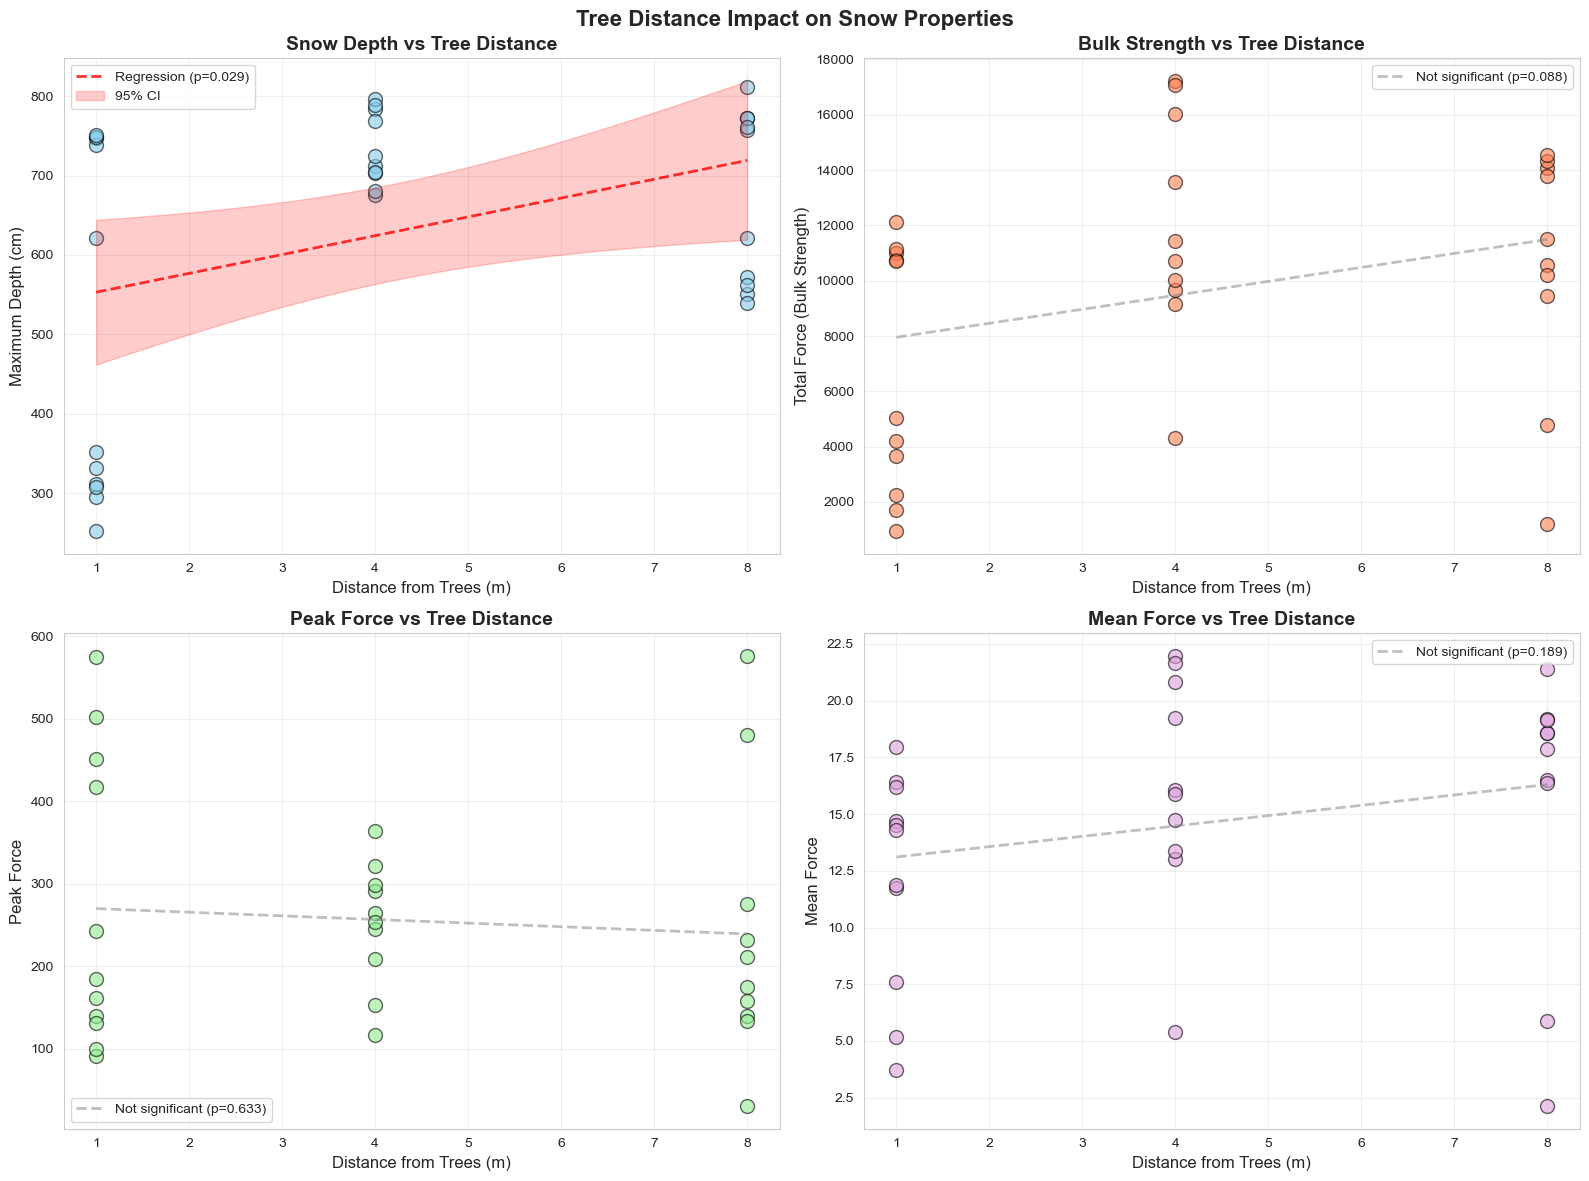

In [45]:
# Remove rows without tree distance data
df_clean = stats_df.dropna(subset=['distance_from_trees_m'])

if len(df_clean) > 0:
    from scipy import stats as sp_stats
    from scipy.stats import t as t_dist
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Common x-axis values for regression lines
    x_line = np.linspace(df_clean['distance_from_trees_m'].min(), 
                         df_clean['distance_from_trees_m'].max(), 100)
    
    def plot_with_ci(ax, x_data, y_data, x_line, color, title, ylabel):
        """Helper function to plot scatter + regression + CI only if significant"""
        ax.scatter(x_data, y_data, s=100, alpha=0.6, edgecolor='black', c=color)
        
        # Calculate regression
        slope, intercept, r_value, p_value, std_err = sp_stats.linregress(x_data, y_data)
        y_pred = slope * x_line + intercept
        
        # Check if significant
        is_significant = p_value < 0.05
        
        if is_significant:
            # Proper confidence interval calculation
            n = len(x_data)
            x_mean = np.mean(x_data)
            sxx = np.sum((x_data - x_mean)**2)
            residuals = y_data - (slope * x_data + intercept)
            s_res = np.sqrt(np.sum(residuals**2) / (n - 2))
            
            # Standard error of prediction
            se = s_res * np.sqrt(1/n + (x_line - x_mean)**2 / sxx)
            
            # 95% confidence interval
            t_val = t_dist.ppf(0.975, n - 2)
            margin = t_val * se
            
            ax.plot(x_line, y_pred, "r--", alpha=0.8, linewidth=2, 
                   label=f'Regression (p={p_value:.3f})')
            ax.fill_between(x_line, y_pred - margin, y_pred + margin, 
                           alpha=0.2, color='red', label='95% CI')
        else:
            # Just show the regression line without CI for non-significant
            ax.plot(x_line, y_pred, "gray", linestyle="--", alpha=0.5, linewidth=2,
                   label=f'Not significant (p={p_value:.3f})')
        
        ax.set_xlabel('Distance from Trees (m)', fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Plot 1: Depth vs Tree Distance
    plot_with_ci(axes[0, 0], 
                 df_clean['distance_from_trees_m'], 
                 df_clean['max_depth_cm'],
                 x_line, 'skyblue',
                 'Snow Depth vs Tree Distance',
                 'Maximum Depth (cm)')
    
    # Plot 2: Bulk Strength vs Tree Distance
    plot_with_ci(axes[0, 1], 
                 df_clean['distance_from_trees_m'], 
                 df_clean['total_force'],
                 x_line, 'coral',
                 'Bulk Strength vs Tree Distance',
                 'Total Force (Bulk Strength)')
    
    # Plot 3: Peak Force vs Tree Distance
    plot_with_ci(axes[1, 0], 
                 df_clean['distance_from_trees_m'], 
                 df_clean['max_force'],
                 x_line, 'lightgreen',
                 'Peak Force vs Tree Distance',
                 'Peak Force')
    
    # Plot 4: Mean Force vs Tree Distance
    plot_with_ci(axes[1, 1], 
                 df_clean['distance_from_trees_m'], 
                 df_clean['mean_force'],
                 x_line, 'plum',
                 'Mean Force vs Tree Distance',
                 'Mean Force')
    
    plt.suptitle('Tree Distance Impact on Snow Properties', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("No data available for plotting")

## 11. Box Plots by Distance Category

Compare Near/Medium/Far locations:

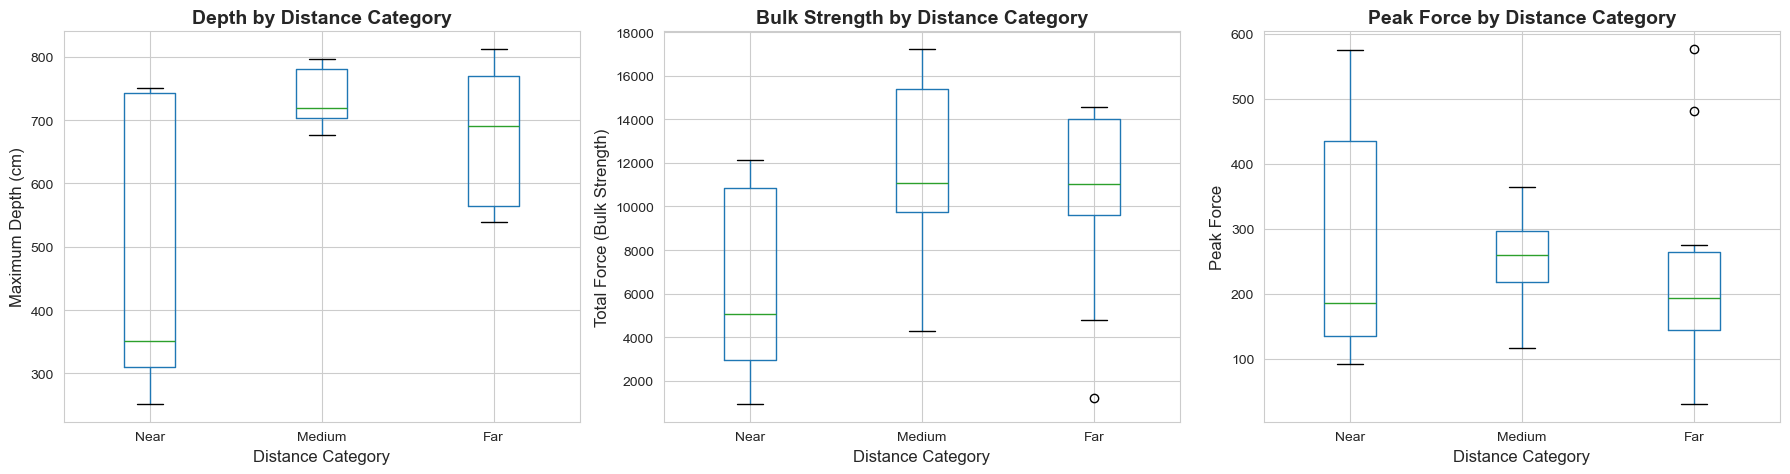


Statistics by Distance Category:

Depth (cm):
                   count        mean         std    min    25%    50%     75%  \
distance_category                                                               
Near                11.0  496.090909  219.766446  252.0  310.0  352.0  743.00   
Medium              10.0  734.000000   46.108568  676.0  703.5  718.5  780.25   
Far                 10.0  672.100000  111.478399  539.0  564.5  690.0  769.25   

                     max  
distance_category         
Near               751.0  
Medium             796.0  
Far                812.0  

Bulk Strength:
                   count          mean          std      min        25%  \
distance_category                                                         
Near                11.0   6684.766364  4428.778846   942.51  2953.4950   
Medium              10.0  11919.579000  4085.043503  4300.60  9768.1575   
Far                 10.0  10442.371000  4426.685892  1196.45  9620.3675   

                    

/var/folders/3j/6dy_9gxj7vvgct178jkkp1680000gn/T/ipykernel_30797/420597292.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_clean.groupby('distance_category')['max_depth_cm'].describe())
/var/folders/3j/6dy_9gxj7vvgct178jkkp1680000gn/T/ipykernel_30797/420597292.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_clean.groupby('distance_category')['total_force'].describe())


In [46]:
if len(df_clean) > 0:
    # Create distance categories
    df_clean['distance_category'] = pd.cut(df_clean['distance_from_trees_m'], 
                                            bins=3, labels=['Near', 'Medium', 'Far'])
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Depth by category
    df_clean.boxplot(column='max_depth_cm', by='distance_category', ax=axes[0])
    axes[0].set_xlabel('Distance Category', fontsize=12)
    axes[0].set_ylabel('Maximum Depth (cm)', fontsize=12)
    axes[0].set_title('Depth by Distance Category', fontsize=14, fontweight='bold')
    axes[0].get_figure().suptitle('')  # Remove automatic title
    
    # Bulk strength by category
    df_clean.boxplot(column='total_force', by='distance_category', ax=axes[1])
    axes[1].set_xlabel('Distance Category', fontsize=12)
    axes[1].set_ylabel('Total Force (Bulk Strength)', fontsize=12)
    axes[1].set_title('Bulk Strength by Distance Category', fontsize=14, fontweight='bold')
    axes[1].get_figure().suptitle('')
    
    # Peak force by category
    df_clean.boxplot(column='max_force', by='distance_category', ax=axes[2])
    axes[2].set_xlabel('Distance Category', fontsize=12)
    axes[2].set_ylabel('Peak Force', fontsize=12)
    axes[2].set_title('Peak Force by Distance Category', fontsize=14, fontweight='bold')
    axes[2].get_figure().suptitle('')
    
    plt.tight_layout()
    plt.show()
    
    # Print category statistics
    print("\nStatistics by Distance Category:")
    print("\nDepth (cm):")
    print(df_clean.groupby('distance_category')['max_depth_cm'].describe())
    print("\nBulk Strength:")
    print(df_clean.groupby('distance_category')['total_force'].describe())
else:
    print("No data available for plotting")

## 12. Compare Example Profiles

Show force profiles from near, medium, and far locations:

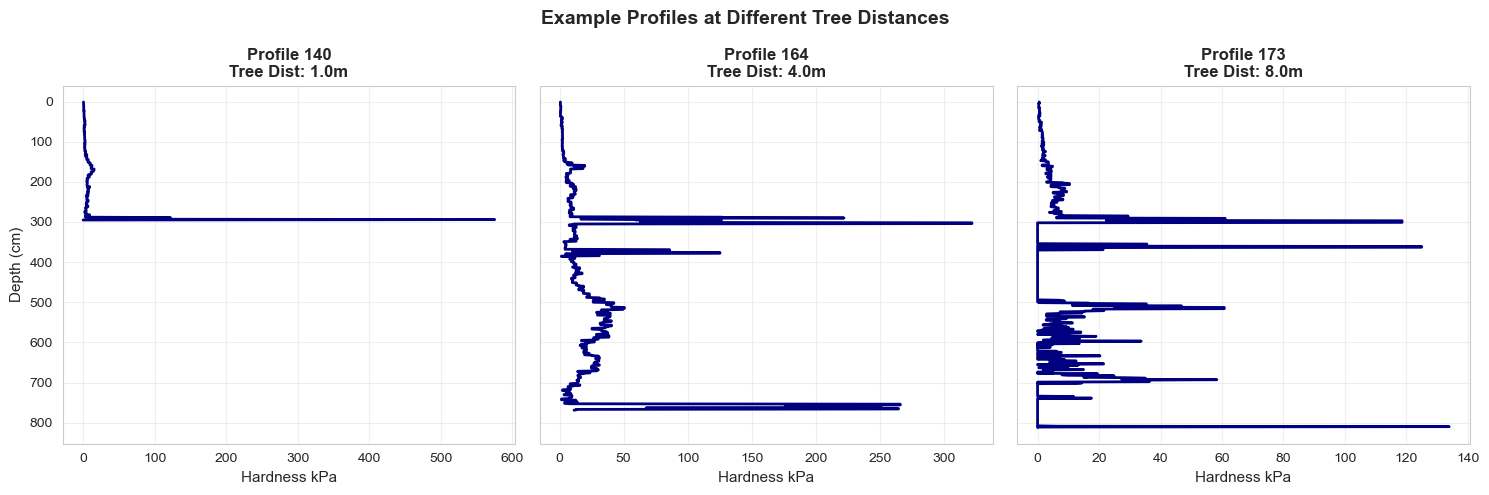

In [47]:
if len(df_clean) > 0:
    # Sort by tree distance and select examples
    df_sorted = df_clean.sort_values('distance_from_trees_m')
    
    # Select profiles: closest, medium, and farthest
    n_profiles = len(df_sorted)
    indices = [0, n_profiles//2, n_profiles-1]
    selected_profiles = df_sorted.iloc[indices]['profile_number'].values
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    
    for idx, profile_num in enumerate(selected_profiles):
        # Find the data for this profile
        for filename, df, pnum in data_files:
            if pnum == profile_num:
                depth_col = df.columns[0]
                force_col = df.columns[1]
                
                tree_dist = df_sorted[df_sorted['profile_number'] == profile_num]['distance_from_trees_m'].values[0]
                
                axes[idx].plot(df[force_col], df[depth_col], linewidth=2, color='navy')
                axes[idx].invert_yaxis()
                axes[idx].set_title(f'Profile {profile_num}\nTree Dist: {tree_dist:.1f}m', 
                                   fontsize=12, fontweight='bold')
                axes[idx].set_xlabel('Hardness kPa', fontsize=11)
                axes[idx].grid(True, alpha=0.3)
                
                if idx == 0:
                    axes[idx].set_ylabel('Depth (cm)', fontsize=11)
                
                break
    
    plt.suptitle('Example Profiles at Different Tree Distances', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("No data available for plotting")

## Show all measurements grouped by transect and distance from trees

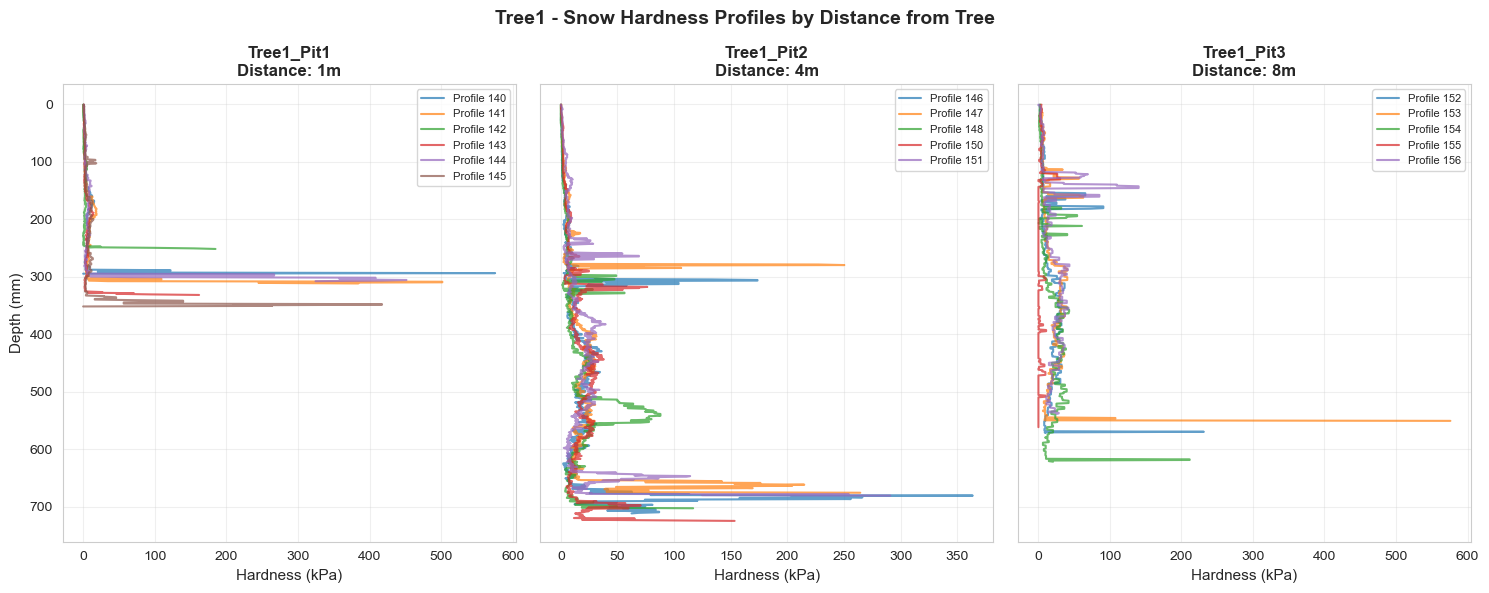

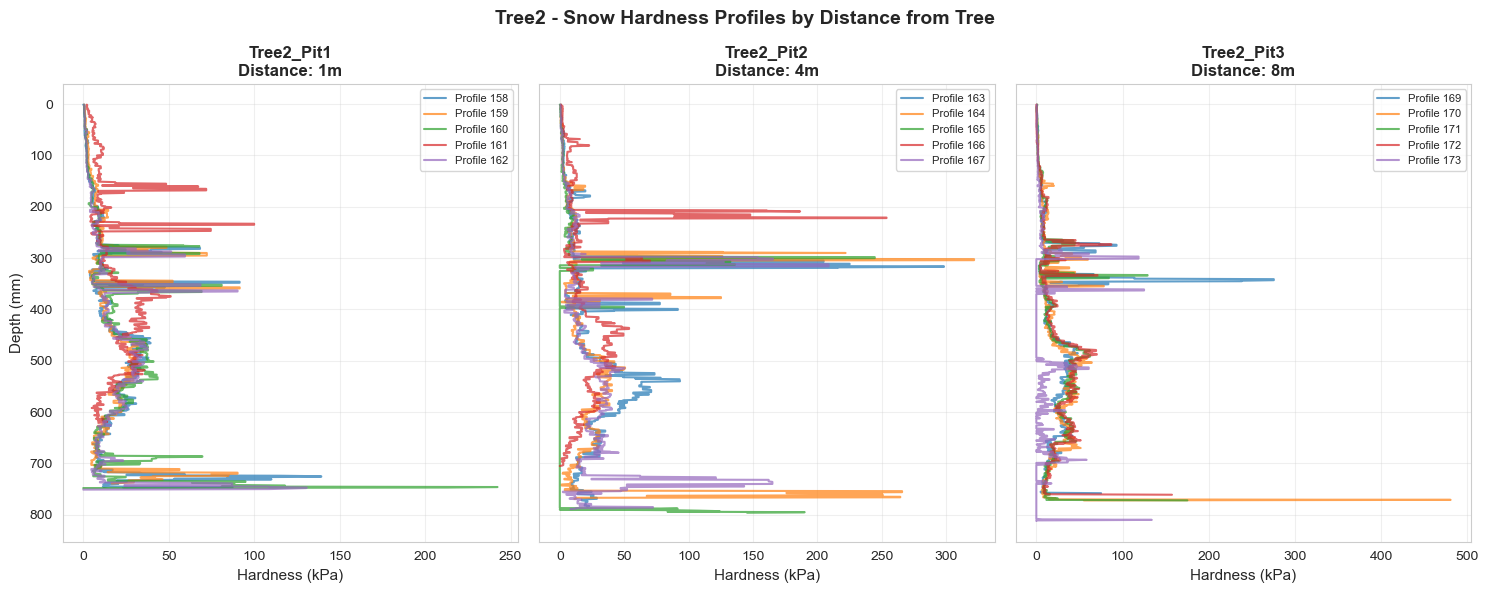

In [48]:
if len(df_clean) > 0:
    # Get PitID information from the tree distance file
    # We need to reload and merge with PitID info
    tree_data_full = pd.read_csv(tree_distance_file)
    
    # Merge to get PitID for each profile
    df_clean_with_pit = df_clean.merge(
        tree_data_full[['ProfileID', 'PitID', 'TreeID']], 
        left_on='profile_number', 
        right_on='ProfileID', 
        how='left'
    )
    
    # Get unique trees
    trees = df_clean_with_pit['TreeID'].dropna().unique()
    
    # Create a figure for each tree
    for tree in trees:
        tree_data = df_clean_with_pit[df_clean_with_pit['TreeID'] == tree]
        
        # Get unique pits for this tree, sorted by distance
        pits = tree_data.sort_values('distance_from_trees_m')['PitID'].unique()
        
        n_pits = len(pits)
        fig, axes = plt.subplots(1, n_pits, figsize=(5*n_pits, 6), sharey=True)
        
        # Handle case of single pit
        if n_pits == 1:
            axes = [axes]
        
        for idx, pit in enumerate(pits):
            pit_profiles = tree_data[tree_data['PitID'] == pit]
            distance = pit_profiles['distance_from_trees_m'].iloc[0]
            
            # Plot all profiles from this pit
            for _, row in pit_profiles.iterrows():
                profile_num = row['profile_number']
                
                # Find the actual profile data
                for filename, df, pnum in data_files:
                    if pnum == profile_num:
                        # Plot hardness profile (x=hardness, y=depth)
                        axes[idx].plot(df['hardness_kPa'], df['depth_mm'], 
                                      linewidth=1.5, alpha=0.7, label=f'Profile {profile_num}')
                        break
            
            axes[idx].invert_yaxis()
            axes[idx].set_title(f'{pit}\nDistance: {distance:.0f}m', 
                               fontsize=12, fontweight='bold')
            axes[idx].set_xlabel('Hardness (kPa)', fontsize=11)
            axes[idx].grid(True, alpha=0.3)
            
            if idx == 0:
                axes[idx].set_ylabel('Depth (mm)', fontsize=11)
            
            # Add legend if multiple profiles
            if len(pit_profiles) > 1:
                axes[idx].legend(fontsize=8, loc='best')
        
        plt.suptitle(f'{tree} - Snow Hardness Profiles by Distance from Tree', 
                     fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
else:
    print("No data available for plotting")

## 13. Export Results

Save statistics to CSV for further analysis:

In [49]:
# Save statistics
output_file = 'snow_scope_statistics_with_trees.csv'
stats_df.to_csv(output_file, index=False)
print(f"✅ Statistics saved to: {output_file}")
print(f"\nSaved {len(stats_df)} profiles with the following columns:")
print(list(stats_df.columns))

✅ Statistics saved to: snow_scope_statistics_with_trees.csv

Saved 31 profiles with the following columns:
['profile_number', 'filename', 'distance_from_trees_m', 'max_depth_cm', 'min_depth_cm', 'mean_force', 'max_force', 'median_force', 'std_force', 'total_force', 'n_measurements']


## 14. Summary Report

Generate a final summary of findings:

In [50]:
print("=" * 80)
print("FINAL SUMMARY REPORT")
print("=" * 80)

print(f"\n📊 Dataset Overview:")
print(f"   Total profiles analyzed: {len(stats_df)}")
print(f"   Profiles with tree distance data: {len(df_clean)}")
print(f"   Tree distance range: {df_clean['distance_from_trees_m'].min():.1f} - {df_clean['distance_from_trees_m'].max():.1f} m")

print(f"\n📏 Snow Depth:")
print(f"   Mean: {stats_df['max_depth_cm'].mean():.2f} cm (±{stats_df['max_depth_cm'].std():.2f})")
print(f"   Range: {stats_df['max_depth_cm'].min():.2f} - {stats_df['max_depth_cm'].max():.2f} cm")

print(f"\n💪 Bulk Strength:")
print(f"   Mean: {stats_df['total_force'].mean():.2f} (±{stats_df['total_force'].std():.2f})")
print(f"   Range: {stats_df['total_force'].min():.2f} - {stats_df['total_force'].max():.2f}")

if correlations:
    print(f"\n🔬 Key Findings:")
    for metric, corr_data in correlations.items():
        if corr_data['p'] < 0.05:
            direction = "positive" if corr_data['r'] > 0 else "negative"
            strength = "strong" if abs(corr_data['r']) > 0.7 else "moderate" if abs(corr_data['r']) > 0.4 else "weak"
            print(f"   • {metric}: {strength} {direction} correlation (r={corr_data['r']:.3f}, p={corr_data['p']:.4f})")

print("\n" + "=" * 80)
print("✅ Analysis complete! Check the visualizations above for detailed results.")
print("=" * 80)

FINAL SUMMARY REPORT

📊 Dataset Overview:
   Total profiles analyzed: 31
   Profiles with tree distance data: 31
   Tree distance range: 1.0 - 8.0 m

📏 Snow Depth:
   Mean: 629.61 cm (±176.74)
   Range: 252.00 - 812.00 cm

💪 Bulk Strength:
   Mean: 9585.55 (±4750.67)
   Range: 942.51 - 17222.28

🔬 Key Findings:
   • depth: weak positive correlation (r=0.393, p=0.0287)

✅ Analysis complete! Check the visualizations above for detailed results.


## 15. Now looking at our snow pit data 

Analyzing grain type by depth, and whether the grain type correlates with that layer range's hardness. 



In [51]:
# Data check 
print("=" * 80)
print("GRAIN TYPE vs HARDNESS ANALYSIS")
print("=" * 80)

# Load the manual snow pit stratigraphy data
strat_file = '/Users/milliespencer/Desktop/snowscope_berthoud/tree_dist_and_strat/Pit_Stratigraphy_Processed.csv'
strat_data = pd.read_csv(strat_file)

print("Loaded stratigraphy data")
print(f"Total rows: {len(strat_data)}")

# Check what columns exist
print("\nColumn names in the file:")
print(strat_data.columns.tolist())

print("\nFirst few rows:")
display(strat_data.head(10))

print("\nData types:")
print(strat_data.dtypes)

GRAIN TYPE vs HARDNESS ANALYSIS
Loaded stratigraphy data
Total rows: 30

Column names in the file:
['PitID', 'Top', 'Bottom', 'Grain.Size', 'Grain.Type', 'Comments', 'TreeID', 'Pit_index', 'Distance_from_tree_meters']

First few rows:


,PitID,Top,Bottom,Grain.Size,Grain.Type,Comments,TreeID,Pit_index,Distance_from_tree_meters
0,Tree1_Pit1,38.0,33.0,1-2 mm,"PP, DF",NaN,Tree1,Pit1,1
1,Tree1_Pit1,33.0,24.5,1-2 mm,DF,NaN,Tree1,Pit1,1
2,Tree1_Pit1,24.5,23.5,1-2 mm,MFcr,"Looks darker, pine needles within",Tree1,Pit1,1
3,Tree1_Pit1,23.5,9.0,1-2 mm,FC,1 mm,Tree1,Pit1,1
4,Tree1_Pit1,9.0,0.0,1-2 mm,DH,Pine needles and crust,Tree1,Pit1,1
5,Tree1_Pit2,74.0,69.0,1-2 mm,"PP, DF",NaN,Tree1,Pit2,4
6,Tree1_Pit2,69.0,48.0,1-2 mm,DF,PP might be from precipitation when observation,Tree1,Pit2,4
7,Tree1_Pit2,48.0,40.0,1-2 mm,MFcr,NaN,Tree1,Pit2,4
8,Tree1_Pit2,40.0,20.0,1-2 mm,FC,close to 2mm,Tree1,Pit2,4
9,Tree1_Pit2,20.0,0.0,1-2 mm,DH,has baby tree pines (<10cm),Tree1,Pit2,4



Data types:
PitID                         object
Top                          float64
Bottom                       float64
Grain.Size                    object
Grain.Type                    object
Comments                      object
TreeID                        object
Pit_index                     object
Distance_from_tree_meters      int64
dtype: object


GRAIN TYPE vs HARDNESS ANALYSIS
Loaded stratigraphy data
Total rows: 30
Rows with grain type and size: 30

Unique grain types found: ['PP, DF' 'DF' 'MFcr' 'FC' 'DH']
Unique pits: ['Tree1_Pit1' 'Tree1_Pit2' 'Tree1_Pit3' 'Tree2_Pit1' 'Tree2_Pit2'
 'Tree2_Pit3']

Sample of stratigraphy data:


,PitID,Top,Bottom,Grain.Size,Grain.Type,Comments,TreeID,Pit_index,Distance_from_tree_meters
0,Tree1_Pit1,38.0,33.0,1-2 mm,"PP, DF",NaN,Tree1,Pit1,1
1,Tree1_Pit1,33.0,24.5,1-2 mm,DF,NaN,Tree1,Pit1,1
2,Tree1_Pit1,24.5,23.5,1-2 mm,MFcr,"Looks darker, pine needles within",Tree1,Pit1,1
3,Tree1_Pit1,23.5,9.0,1-2 mm,FC,1 mm,Tree1,Pit1,1
4,Tree1_Pit1,9.0,0.0,1-2 mm,DH,Pine needles and crust,Tree1,Pit1,1
5,Tree1_Pit2,74.0,69.0,1-2 mm,"PP, DF",NaN,Tree1,Pit2,4
6,Tree1_Pit2,69.0,48.0,1-2 mm,DF,PP might be from precipitation when observation,Tree1,Pit2,4
7,Tree1_Pit2,48.0,40.0,1-2 mm,MFcr,NaN,Tree1,Pit2,4
8,Tree1_Pit2,40.0,20.0,1-2 mm,FC,close to 2mm,Tree1,Pit2,4
9,Tree1_Pit2,20.0,0.0,1-2 mm,DH,has baby tree pines (<10cm),Tree1,Pit2,4



Depth conversion (flipped to match Snow Scope):
Pit notation → Snow Scope notation (shallow-deep)
  38.0-33.0 cm → 0-50 mm
  33.0-24.5 cm → 50-135 mm
  24.5-23.5 cm → 135-145 mm
  23.5-9.0 cm → 145-290 mm
  9.0-0.0 cm → 290-380 mm

MATCHING GRAIN TYPES WITH SNOW SCOPE HARDNESS

Matched 30 grain type layers with Snow Scope data

Summary by grain type:
            count       mean        std
Grain_Type                             
DF              6   8.425645   4.266238
DH              6  28.694176  16.830651
FC              6  19.571316   6.201722
MFcr            6  15.779038   5.831133
PP, DF          6   1.904561   1.141548

HARDNESS BY GRAIN TYPE

DF:
  Number of layers: 6
  Mean hardness: 8.43 ± 4.27 kPa
  Median hardness: 8.93 kPa
  Range: 2.90 - 14.40 kPa

DH:
  Number of layers: 6
  Mean hardness: 28.69 ± 16.83 kPa
  Median hardness: 25.23 kPa
  Range: 11.57 - 60.92 kPa

FC:
  Number of layers: 6
  Mean hardness: 19.57 ± 6.20 kPa
  Median hardness: 20.73 kPa
  Range: 7.67 - 26.0

/var/folders/3j/6dy_9gxj7vvgct178jkkp1680000gn/T/ipykernel_30797/3580576454.py:127: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_for_box, labels=grain_types, patch_artist=True)


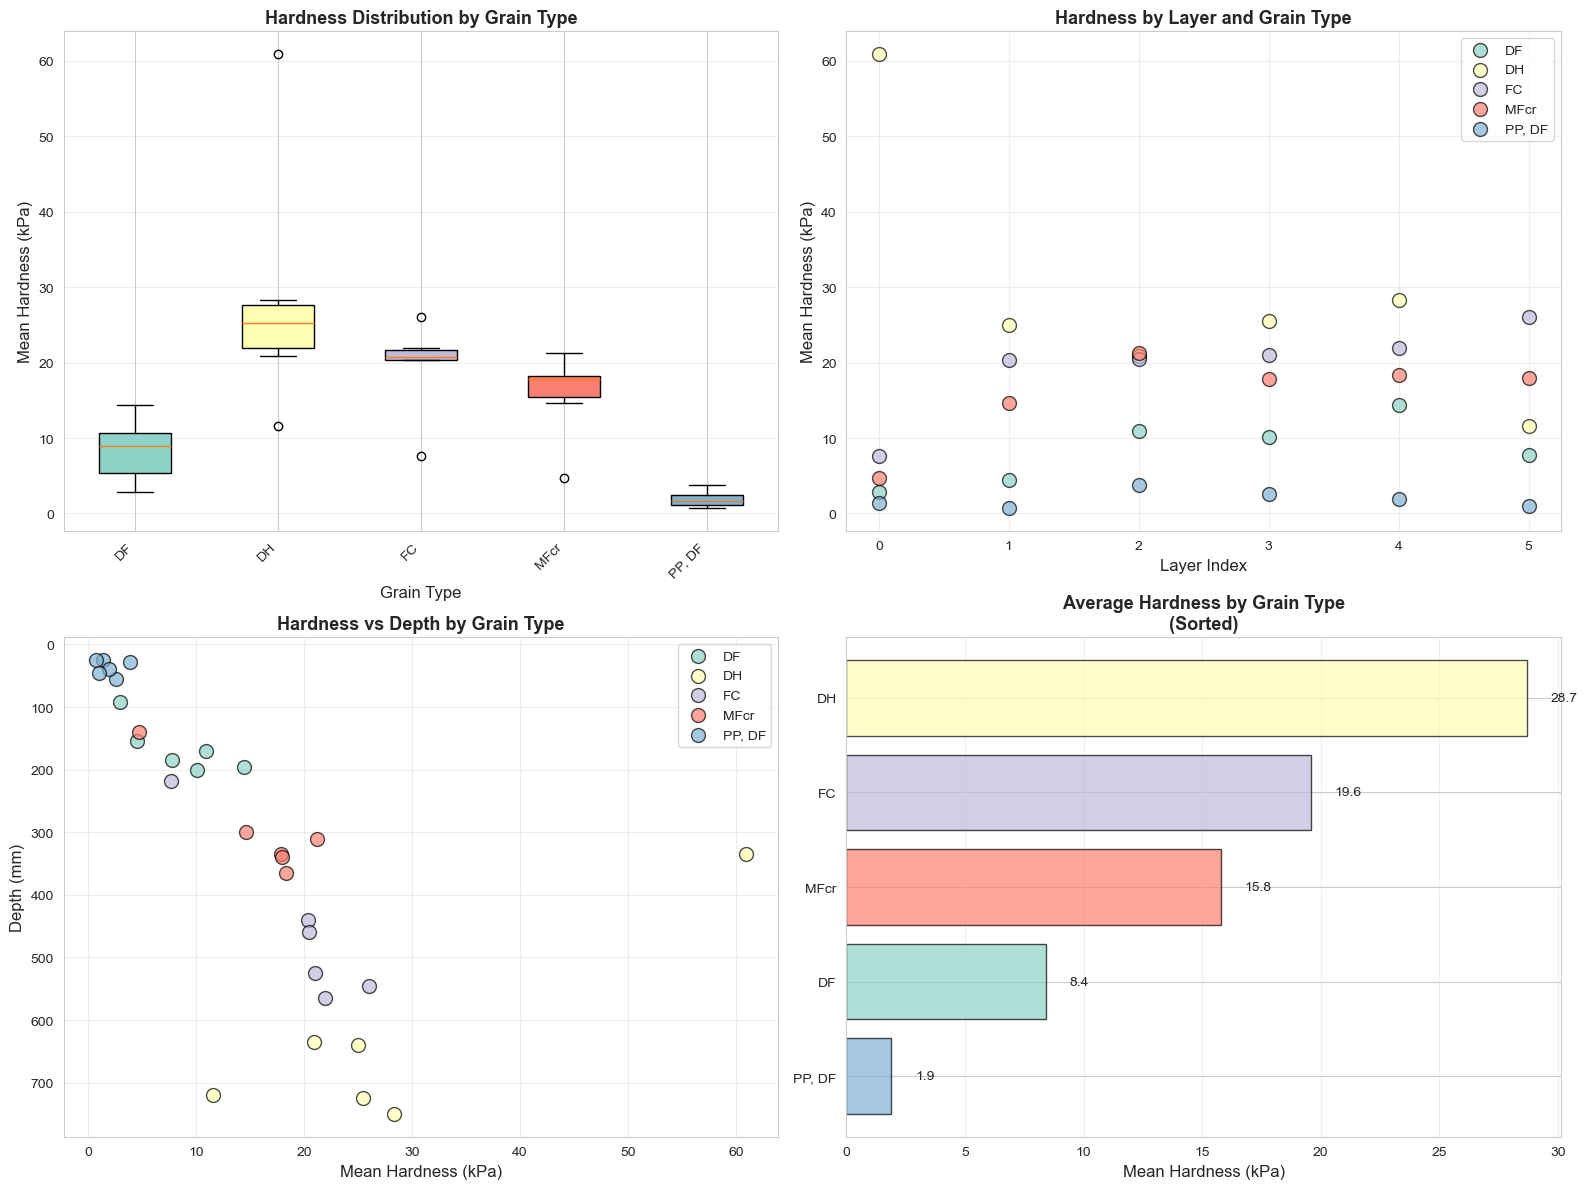


STATISTICAL TESTS

One-way ANOVA test:
  F-statistic: 8.468
  p-value: 0.0002
  ✓ Significant: Different grain types have significantly different hardness



In [56]:
# Analyze relationship between manual snow pit grain types and Snow Scope hardness

print("=" * 80)
print("GRAIN TYPE vs HARDNESS ANALYSIS")
print("=" * 80)

# Load the manual snow pit stratigraphy data
strat_file = '/Users/milliespencer/Desktop/snowscope_berthoud/tree_dist_and_strat/Pit_Stratigraphy_Processed.csv'
strat_data = pd.read_csv(strat_file)

print("Loaded stratigraphy data")
print(f"Total rows: {len(strat_data)}")

# Filter to only rows with grain type and grain size
strat_clean = strat_data.dropna(subset=['Grain.Type', 'Grain.Size'])

print(f"Rows with grain type and size: {len(strat_clean)}")
print(f"\nUnique grain types found: {strat_clean['Grain.Type'].unique()}")
print(f"Unique pits: {strat_clean['PitID'].unique()}")

# Display sample data
print("\nSample of stratigraphy data:")
display(strat_clean.head(10))

# Convert depth ranges from cm to mm
# In pit observations: Top = surface (e.g., 60cm), Bottom = ground (0cm)
# Need to FLIP this to match Snow Scope convention where depth increases downward
strat_clean = strat_clean.copy()

# Get total snow depth for each pit to flip the measurements
for pit_id in strat_clean['PitID'].unique():
    pit_rows = strat_clean['PitID'] == pit_id
    max_depth_cm = strat_clean.loc[pit_rows, 'Top'].max()  # Total snow depth
    
    # Flip the depths: surface (Top) becomes 0, ground (Bottom) becomes max depth
    # Top in pit = surface → becomes shallow in Snow Scope
    # Bottom in pit = ground → becomes deep in Snow Scope
    strat_clean.loc[pit_rows, 'Shallow_mm'] = (max_depth_cm - strat_clean.loc[pit_rows, 'Top']) * 10
    strat_clean.loc[pit_rows, 'Deep_mm'] = (max_depth_cm - strat_clean.loc[pit_rows, 'Bottom']) * 10

strat_clean['Mid_depth_mm'] = (strat_clean['Shallow_mm'] + strat_clean['Deep_mm']) / 2
strat_clean['Layer_thickness_mm'] = strat_clean['Deep_mm'] - strat_clean['Shallow_mm']

print("\nDepth conversion (flipped to match Snow Scope):")
print("Pit notation → Snow Scope notation (shallow-deep)")
for _, row in strat_clean.head(5).iterrows():
    print(f"  {row['Top']:.1f}-{row['Bottom']:.1f} cm → {row['Shallow_mm']:.0f}-{row['Deep_mm']:.0f} mm")

print("\n" + "=" * 80)
print("MATCHING GRAIN TYPES WITH SNOW SCOPE HARDNESS")
print("=" * 80)

# For each grain type layer, get all Snow Scope hardness measurements within that depth range
grain_hardness_data = []

for _, layer in strat_clean.iterrows():
    pit_id = layer['PitID']
    grain_type = layer['Grain.Type']
    shallow_mm = layer['Shallow_mm']  # Shallower depth (smaller number)
    deep_mm = layer['Deep_mm']  # Deeper depth (larger number)
    mid_depth = layer['Mid_depth_mm']
    grain_size = layer['Grain.Size']
    
    # Get all profiles from this pit
    pit_profiles = tree_data_full[tree_data_full['PitID'] == pit_id]['ProfileID'].values
    
    # Collect all hardness measurements within this depth range
    hardness_in_layer = []
    
    for profile_num in pit_profiles:
        for filename, df, pnum in data_files:
            if pnum == profile_num:
                # Find measurements within this depth range
                in_range = df[(df['depth_mm'] >= shallow_mm) & (df['depth_mm'] <= deep_mm)]
                if len(in_range) > 0:
                    hardness_in_layer.extend(in_range['hardness_kPa'].values)
                break
    
    if len(hardness_in_layer) > 0:
        grain_hardness_data.append({
            'PitID': pit_id,
            'Grain_Type': grain_type,
            'Grain_Size': grain_size,
            'Shallow_mm': shallow_mm,
            'Deep_mm': deep_mm,
            'Mid_depth_mm': mid_depth,
            'Layer_thickness_mm': deep_mm - shallow_mm,
            'n_measurements': len(hardness_in_layer),
            'mean_hardness_kPa': np.mean(hardness_in_layer),
            'std_hardness_kPa': np.std(hardness_in_layer),
            'median_hardness_kPa': np.median(hardness_in_layer),
            'max_hardness_kPa': np.max(hardness_in_layer),
            'min_hardness_kPa': np.min(hardness_in_layer)
        })

grain_hardness_df = pd.DataFrame(grain_hardness_data)

print(f"\nMatched {len(grain_hardness_df)} grain type layers with Snow Scope data")

if len(grain_hardness_df) > 0:
    print(f"\nSummary by grain type:")
    summary = grain_hardness_df.groupby('Grain_Type')['mean_hardness_kPa'].agg(['count', 'mean', 'std'])
    print(summary)

    # Statistical comparison of grain types
    print("\n" + "=" * 80)
    print("HARDNESS BY GRAIN TYPE")
    print("=" * 80)

    for grain_type in sorted(grain_hardness_df['Grain_Type'].unique()):
        grain_data = grain_hardness_df[grain_hardness_df['Grain_Type'] == grain_type]
        print(f"\n{grain_type}:")
        print(f"  Number of layers: {len(grain_data)}")
        print(f"  Mean hardness: {grain_data['mean_hardness_kPa'].mean():.2f} ± {grain_data['mean_hardness_kPa'].std():.2f} kPa")
        print(f"  Median hardness: {grain_data['mean_hardness_kPa'].median():.2f} kPa")
        print(f"  Range: {grain_data['mean_hardness_kPa'].min():.2f} - {grain_data['mean_hardness_kPa'].max():.2f} kPa")

    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Plot 1: Box plot of hardness by grain type
    ax = axes[0, 0]
    grain_types = sorted(grain_hardness_df['Grain_Type'].unique())
    data_for_box = [grain_hardness_df[grain_hardness_df['Grain_Type'] == gt]['mean_hardness_kPa'].values 
                    for gt in grain_types]

    bp = ax.boxplot(data_for_box, labels=grain_types, patch_artist=True)
    for patch, color in zip(bp['boxes'], plt.cm.Set3(range(len(grain_types)))):
        patch.set_facecolor(color)

    ax.set_ylabel('Mean Hardness (kPa)', fontsize=12)
    ax.set_xlabel('Grain Type', fontsize=12)
    ax.set_title('Hardness Distribution by Grain Type', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

    # Plot 2: Scatter plot - each layer
    ax = axes[0, 1]
    colors_map = {gt: plt.cm.Set3(i) for i, gt in enumerate(grain_types)}
    for grain_type in grain_types:
        grain_data = grain_hardness_df[grain_hardness_df['Grain_Type'] == grain_type]
        ax.scatter(range(len(grain_data)), grain_data['mean_hardness_kPa'],
                  s=100, alpha=0.7, label=grain_type, color=colors_map[grain_type],
                  edgecolor='black')

    ax.set_xlabel('Layer Index', fontsize=12)
    ax.set_ylabel('Mean Hardness (kPa)', fontsize=12)
    ax.set_title('Hardness by Layer and Grain Type', fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot 3: Hardness by depth, colored by grain type
    ax = axes[1, 0]
    for grain_type in grain_types:
        grain_data = grain_hardness_df[grain_hardness_df['Grain_Type'] == grain_type]
        ax.scatter(grain_data['mean_hardness_kPa'], grain_data['Mid_depth_mm'],
                  s=100, alpha=0.7, label=grain_type, color=colors_map[grain_type],
                  edgecolor='black')

    ax.invert_yaxis()
    ax.set_xlabel('Mean Hardness (kPa)', fontsize=12)
    ax.set_ylabel('Depth (mm)', fontsize=12)
    ax.set_title('Hardness vs Depth by Grain Type', fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot 4: Bar chart comparing mean hardness
    ax = axes[1, 1]
    grain_means = grain_hardness_df.groupby('Grain_Type')['mean_hardness_kPa'].mean().sort_values()
    colors = [colors_map[gt] for gt in grain_means.index]
    bars = ax.barh(range(len(grain_means)), grain_means.values, color=colors, 
                   edgecolor='black', alpha=0.7)
    ax.set_yticks(range(len(grain_means)))
    ax.set_yticklabels(grain_means.index)
    ax.set_xlabel('Mean Hardness (kPa)', fontsize=12)
    ax.set_title('Average Hardness by Grain Type\n(Sorted)', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')

    # Add value labels
    for i, (grain, value) in enumerate(grain_means.items()):
        ax.text(value + 1, i, f'{value:.1f}', va='center', fontsize=10)

    plt.tight_layout()
    plt.show()

    # Statistical tests
    print("\n" + "=" * 80)
    print("STATISTICAL TESTS")
    print("=" * 80)

    # ANOVA test - are there significant differences between grain types?
    if len(grain_types) >= 2:
        from scipy.stats import f_oneway
        
        groups = [grain_hardness_df[grain_hardness_df['Grain_Type'] == gt]['mean_hardness_kPa'].values 
                  for gt in grain_types]
        
        # Remove empty groups
        groups = [g for g in groups if len(g) > 0]
        
        if len(groups) >= 2:
            f_stat, p_val = f_oneway(*groups)
            print(f"\nOne-way ANOVA test:")
            print(f"  F-statistic: {f_stat:.3f}")
            print(f"  p-value: {p_val:.4f}")
            
            if p_val < 0.05:
                print(f"  ✓ Significant: Different grain types have significantly different hardness")
            else:
                print(f"  ✗ Not significant: No significant difference in hardness between grain types")

    print("\n" + "=" * 80)
else:
    print("\n⚠️  No matching data found between grain types and Snow Scope measurements")
    print("Check that PitIDs match between the two files")

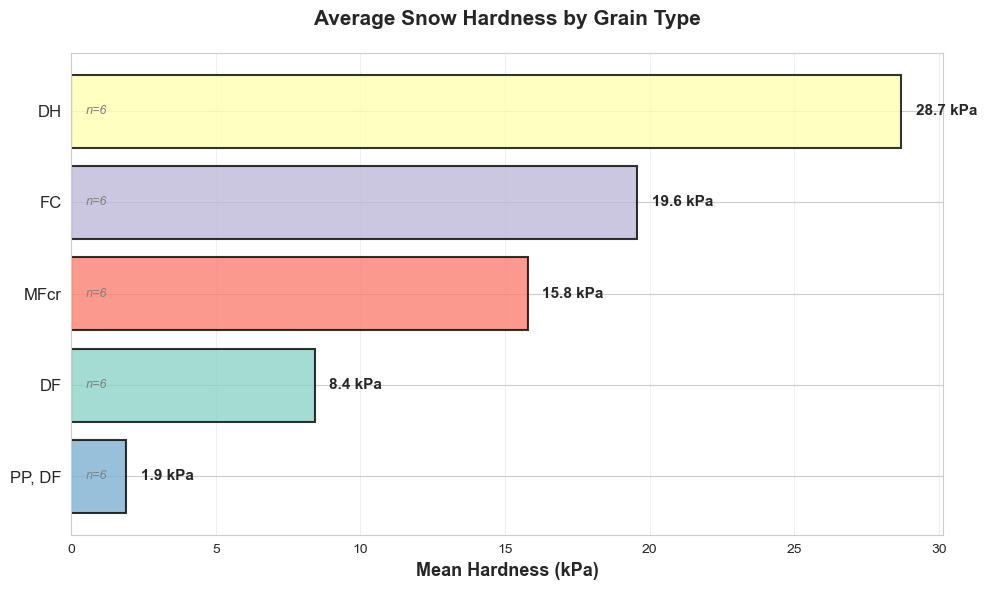


GRAIN TYPE HARDNESS RANKING (softest to hardest)
  1. PP, DF         : 1.90 kPa (n=6 layers)
  2. DF             : 8.43 kPa (n=6 layers)
  3. MFcr           : 15.78 kPa (n=6 layers)
  4. FC             : 19.57 kPa (n=6 layers)
  5. DH             : 28.69 kPa (n=6 layers)


In [57]:
# Create standalone plot: Average Hardness by Grain Type

if len(grain_hardness_df) > 0:
    # Calculate mean hardness for each grain type and sort
    grain_means = grain_hardness_df.groupby('Grain_Type')['mean_hardness_kPa'].mean().sort_values()
    
    # Create color map
    grain_types = sorted(grain_hardness_df['Grain_Type'].unique())
    colors_map = {gt: plt.cm.Set3(i) for i, gt in enumerate(grain_types)}
    colors = [colors_map[gt] for gt in grain_means.index]
    
    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    # Create horizontal bar chart
    bars = ax.barh(range(len(grain_means)), grain_means.values, color=colors, 
                   edgecolor='black', alpha=0.8, linewidth=1.5)
    
    # Customize axes
    ax.set_yticks(range(len(grain_means)))
    ax.set_yticklabels(grain_means.index, fontsize=12)
    ax.set_xlabel('Mean Hardness (kPa)', fontsize=13, fontweight='bold')
    ax.set_title('Average Snow Hardness by Grain Type', 
                fontsize=15, fontweight='bold', pad=20)
    ax.grid(True, alpha=0.3, axis='x')
    
    # Add value labels on bars
    for i, (grain, value) in enumerate(grain_means.items()):
        ax.text(value + 0.5, i, f'{value:.1f} kPa', 
               va='center', fontsize=11, fontweight='bold')
    
    # Add sample size labels
    grain_counts = grain_hardness_df.groupby('Grain_Type').size()
    for i, grain in enumerate(grain_means.index):
        n = grain_counts[grain]
        ax.text(0.5, i, f'n={n}', va='center', ha='left', 
               fontsize=9, style='italic', color='gray')
    
    plt.tight_layout()
    plt.show()
    
    # Print ranking
    print("\n" + "=" * 80)
    print("GRAIN TYPE HARDNESS RANKING (softest to hardest)")
    print("=" * 80)
    for i, (grain, value) in enumerate(grain_means.items(), 1):
        n = grain_counts[grain]
        print(f"  {i}. {grain:15s}: {value:.2f} kPa (n={n} layers)")
    print("=" * 80)
else:
    print("No data available to plot")